In [5]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer
from transformers import TrainingArguments


# Load datasets
train_df = pd.read_csv("D:\cse465_Pro\Train.csv")
test_df = pd.read_csv("D:\cse465_Pro\Test.csv")
val_df = pd.read_csv("D:\cse465_Pro\Val.csv")

# Rename labels
label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
train_df["Label"] = train_df["Label"].map(label_mapping)
test_df["Label"] = test_df["Label"].map(label_mapping)
val_df["Label"] = val_df["Label"].map(label_mapping)

# Check for missing values and shuffle
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
val_df.dropna(inplace=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert to Hugging Face dataset
def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Encode labels
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}

dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'csebuetnlp/banglabert'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy='epoch',
    load_best_model_at_end=True,
    report_to=[]
)

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],  # Use validation set for evaluation
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    }
)

# Train model
trainer.train()

# Evaluate model on validation set
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Final evaluation on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


Map: 100%|██████████| 1586/1586 [00:00<00:00, 775310.74 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 27822.97 examples/s]


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [ ]:
trainer.save_model('BanglaBERT_Model')

Map: 100%|██████████| 1586/1586 [00:00<00:00, 93370.29 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 33913.32 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_13332\2516724338.py:104: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`.

Step,Training Loss
10,1.078900
20,1.071000
30,1.017900
40,1.003400
50,0.893600
60,0.869400
70,0.865600
80,0.764700
90,0.853600
100,0.890100


Validation Results: {'eval_loss': 1.1300071477890015, 'eval_accuracy': 0.7657945118059988, 'eval_f1': 0.7625211625908024, 'eval_runtime': 5.0759, 'eval_samples_per_second': 308.715, 'eval_steps_per_second': 9.653, 'epoch': 10.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.55      0.44      0.49       361
    Positive       0.78      0.83      0.81       654
    Negative       0.78      0.82      0.80       571

    accuracy                           0.74      1586
   macro avg       0.70      0.70      0.70      1586
weighted avg       0.73      0.74      0.73      1586



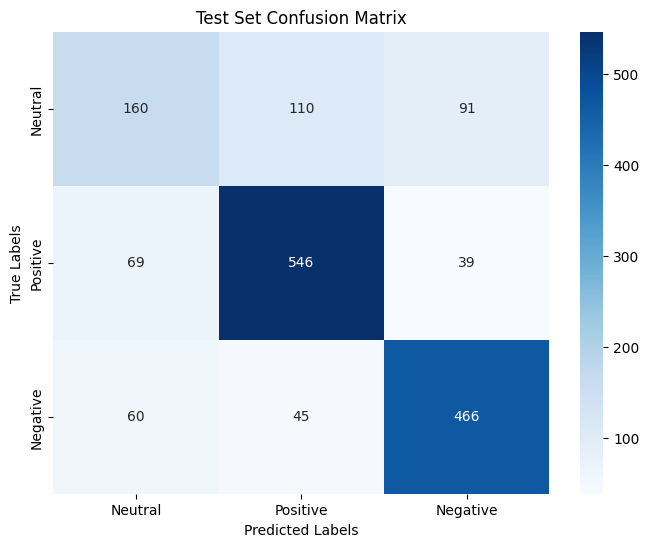

In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW

# Load datasets
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")

# Rename labels
label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
train_df["Label"] = train_df["Label"].map(label_mapping)
test_df["Label"] = test_df["Label"].map(label_mapping)
val_df["Label"] = val_df["Label"].map(label_mapping)

# Drop missing and shuffle
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
val_df.dropna(inplace=True)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)
val_df = val_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Convert to Hugging Face Dataset
def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Label encoding
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Load model and tokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'csebuetnlp/banglabert'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list)).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization
def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# # Training Arguments (No incompatible keys)

training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
    # Removed evaluation_strategy, save_strategy, etc.
)


# Optimizer and LR scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = (len(dataset["train"]) // training_args.per_device_train_batch_size) * training_args.num_train_epochs
lr_scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1)),
        "f1": f1_score(eval_pred.label_ids, np.argmax(eval_pred.predictions, axis=-1), average="weighted")
    },
    optimizers=(optimizer, lr_scheduler)
)

# Training
trainer.train()

# Validation evaluation
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Final test evaluation
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [3]:
trainer.save_model('BanglaBERT_Model_2')

c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 34320.12 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

trainable params: 887,811 || all params: 111,507,462 || trainable%: 0.7962


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
10,1.080800
20,1.061900
30,1.038700
40,1.052400
50,0.980400
60,0.888300
70,0.838000
80,0.805000
90,0.757300
100,0.837500


Validation Results: {'eval_loss': 0.6592229008674622, 'eval_accuracy': 0.7319719208679004, 'eval_f1': 0.725679775565163, 'eval_runtime': 1.2371, 'eval_samples_per_second': 1266.719, 'eval_steps_per_second': 39.61, 'epoch': 10.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.56      0.42      0.48       361
    Positive       0.78      0.81      0.80       654
    Negative       0.76      0.84      0.80       571

    accuracy                           0.74      1586
   macro avg       0.70      0.69      0.69      1586
weighted avg       0.72      0.74      0.73      1586



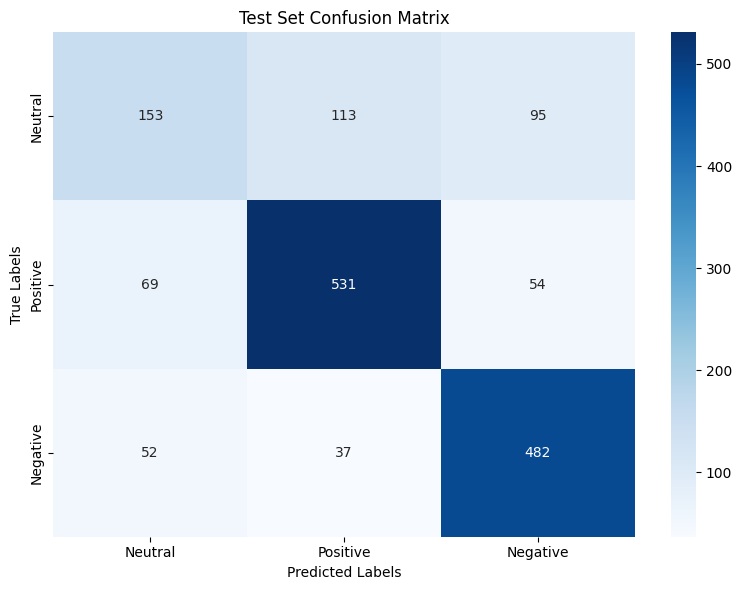

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from peft import get_peft_model, LoraConfig, TaskType

# Load and preprocess dataset
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
for df in [train_df, test_df, val_df]:
    df["Label"] = df["Label"].map(label_mapping)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Label encoding
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Tokenizer
model_name = 'csebuetnlp/banglabert'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Load base model (no quantization)
base_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list)
)

# Apply LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    task_type=TaskType.SEQ_CLS,
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(base_model, peft_config)
model.print_trainable_parameters()

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,
    logging_dir='./logs',
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    save_steps=500,  # Older versions save checkpoints this way
    save_total_limit=2,  # Optional: to limit number of saved checkpoints
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    learning_rate=2e-4
)

# Note: You'll need to manually implement evaluation and saving if you're using an older version.


# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate on validation
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Predict on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [2]:
trainer.save_model('BanglaBERT_Model_3')

c:\Users\User\anaconda3\envs\llm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 29419.78 examples/s]
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predict

Step,Training Loss
10,1.090300
20,0.946300
30,0.955600
40,0.919000
50,0.893200
60,0.918200
70,0.905000
80,0.883300
90,0.795800
100,0.899200


Validation Results: {'eval_loss': 1.0709023475646973, 'eval_accuracy': 0.39757498404594765, 'eval_f1': 0.2262001964023976, 'eval_runtime': 1.1887, 'eval_samples_per_second': 1318.28, 'eval_steps_per_second': 41.223, 'epoch': 10.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       361
    Positive       0.41      1.00      0.58       654
    Negative       0.00      0.00      0.00       571

    accuracy                           0.41      1586
   macro avg       0.14      0.33      0.19      1586
weighted avg       0.17      0.41      0.24      1586



c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\envs\llm\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


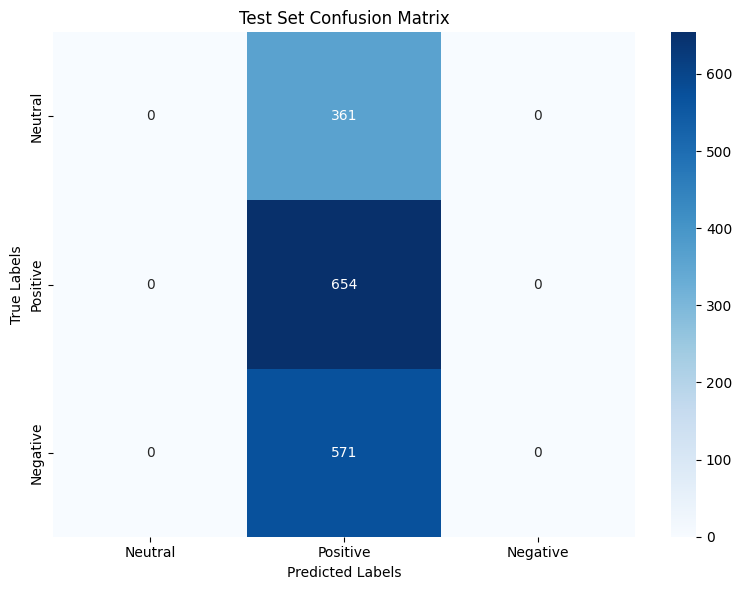

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Load and preprocess dataset
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
for df in [train_df, test_df, val_df]:
    df["Label"] = df["Label"].map(label_mapping)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Label encoding
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Tokenizer
model_name = 'csebuetnlp/banglabert'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Load model for full fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list)
)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,
    logging_dir='./logs',
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    save_steps=500,
    save_total_limit=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,
    learning_rate=2e-4
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

# Evaluate on validation
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Predict on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


Map:   0%|          | 0/12575 [00:00<?, ? examples/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Map: 100%|██████████| 1586/1586 [00:00<00:00, 34943.54 examples/s]
C:\Users\User\AppData\Local\Temp\ipykernel_5568\1307569910.py:81: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-04-14 2

Step,Training Loss
10,1.095200
20,1.020300
30,0.915600
40,1.071200
50,1.027800
60,0.944500
70,0.976400
80,0.997600
90,1.057500
100,0.778700


[I 2025-04-14 21:50:57,354] Trial 0 finished with value: 0.759295395912968 and parameters: {'learning_rate': 0.00010257028070108587, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.0590586709777104}. Best is trial 0 with value: 0.759295395912968.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.153000
20,1.093300
30,1.056900
40,1.071300
50,1.080300
60,1.048000
70,1.073100
80,1.117500
90,1.086900
100,1.028200


[I 2025-04-14 21:56:15,641] Trial 1 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00036255933572168465, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.2955977075046687}. Best is trial 0 with value: 0.759295395912968.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.096800
20,1.040200
30,0.953800
40,0.892700
50,1.030400
60,0.833400
70,0.961400
80,1.010900
90,1.089000
100,0.894100


[I 2025-04-14 22:08:47,585] Trial 2 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00011491465214812784, 'num_train_epochs': 10, 'per_device_train_batch_size': 16, 'weight_decay': 0.08075802415142698}. Best is trial 0 with value: 0.759295395912968.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.089900
20,1.058600
30,1.004300
40,0.959800
50,0.901400
60,0.889500
70,0.958300
80,0.942200
90,1.004200
100,0.765300


[I 2025-04-14 22:17:15,912] Trial 3 finished with value: 0.7598224584437565 and parameters: {'learning_rate': 3.176958105824071e-05, 'num_train_epochs': 7, 'per_device_train_batch_size': 16, 'weight_decay': 0.13593381966039556}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.110100
20,1.029600
30,1.069300
40,1.108400
50,1.067300
60,1.080300
70,1.053100
80,1.089300
90,1.055200
100,1.110200


[I 2025-04-14 22:24:43,973] Trial 4 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00026557434913060336, 'num_train_epochs': 10, 'per_device_train_batch_size': 32, 'weight_decay': 0.07592664117293944}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.126700
20,1.087400
30,1.054500
40,1.059200
50,1.073000
60,1.046300
70,1.068900
80,1.103600
90,1.091400
100,1.025600


[I 2025-04-14 22:29:36,318] Trial 5 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.0002554630910364573, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.16311932475371935}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.121800
20,1.065300
30,1.071200
40,1.121700
50,1.090600
60,1.079500
70,1.060700
80,1.085400
90,1.055500
100,1.109500


[I 2025-04-14 22:31:55,204] Trial 6 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.0004190266453773946, 'num_train_epochs': 3, 'per_device_train_batch_size': 32, 'weight_decay': 0.09159194676541724}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.111500
20,1.057600
30,0.978400
40,1.023300
50,0.963600
60,0.965100
70,0.953000
80,1.001200
90,1.075300
100,1.043000


[I 2025-04-14 22:36:44,289] Trial 7 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00018718434436944883, 'num_train_epochs': 4, 'per_device_train_batch_size': 16, 'weight_decay': 0.1801993741679746}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.137700
20,1.099500
30,1.070200
40,1.080500
50,1.080500
60,1.043000
70,1.063000
80,1.115200
90,1.088400
100,1.025600


[I 2025-04-14 22:42:44,345] Trial 8 finished with value: 0.2262001964023976 and parameters: {'learning_rate': 0.00035535219618998393, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.050379109105615445}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.069100
20,0.903800
30,0.873100
40,0.912900
50,0.818800
60,0.823000
70,0.884200
80,0.872900
90,0.797600
100,0.882600


[I 2025-04-14 22:46:30,980] Trial 9 finished with value: 0.7535279360052035 and parameters: {'learning_rate': 9.54639020373387e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 32, 'weight_decay': 0.19465953670324415}. Best is trial 3 with value: 0.7598224584437565.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions

Step,Training Loss
10,1.089900
20,1.058700
30,1.004300
40,0.959700
50,0.901100
60,0.878800
70,0.931900
80,0.855800
90,0.975500
100,0.679400


Validation Results: {'eval_loss': 1.2230056524276733, 'eval_accuracy': 0.7619655392469687, 'eval_f1': 0.7590450998097483, 'eval_runtime': 4.6782, 'eval_samples_per_second': 334.961, 'eval_steps_per_second': 41.897, 'epoch': 7.0}
Test Set Classification Report:
               precision    recall  f1-score   support

     Neutral       0.58      0.47      0.52       361
    Positive       0.80      0.83      0.81       654
    Negative       0.78      0.84      0.81       571

    accuracy                           0.75      1586
   macro avg       0.72      0.71      0.72      1586
weighted avg       0.74      0.75      0.75      1586



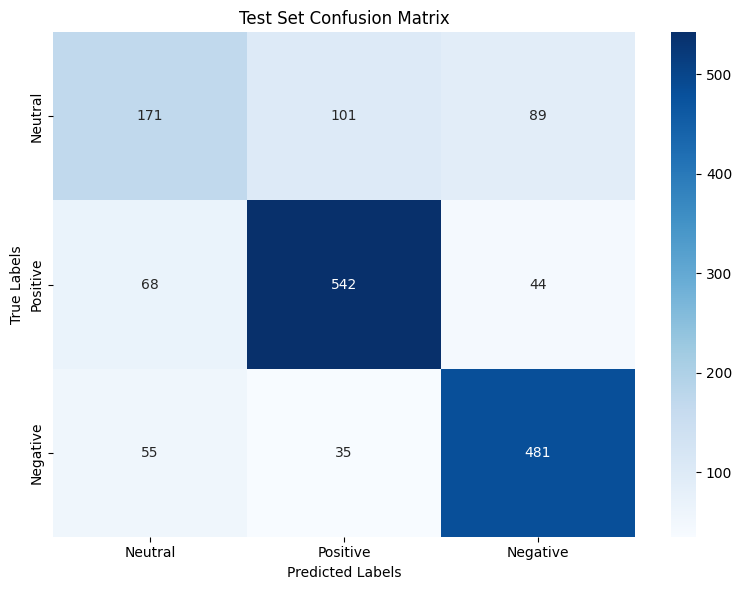

In [6]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
import optuna

# Load and preprocess dataset
train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")

label_mapping = {0: "Neutral", 1: "Positive", 2: "Negative"}
for df in [train_df, test_df, val_df]:
    df["Label"] = df["Label"].map(label_mapping)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

def convert_to_dataset(df):
    return Dataset.from_pandas(pd.DataFrame({'text': df['Data'], 'label': df['Label']}))

dataset = DatasetDict({
    "train": convert_to_dataset(train_df),
    "validation": convert_to_dataset(val_df),
    "test": convert_to_dataset(test_df)
})

# Label encoding
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
dataset = dataset.map(lambda x: {"label": [label_to_id[label] for label in x["label"]]}, batched=True)

# Tokenizer
model_name = 'csebuetnlp/banglabert'
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example['text'], padding='max_length', truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(['text']).rename_column('label', 'labels')
dataset.set_format('torch')

# Define model init function for optuna
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label_list)
    )

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    do_train=True,
    do_eval=True,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available()
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# Define Trainer
trainer = Trainer(
    model_init=model_init,  # ✅ required for hyperparameter search
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Hyperparameter space
def model_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-4, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
    }

# Run hyperparameter search
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=model_hp_space,
    compute_objective=lambda metrics: metrics["eval_f1"],
    n_trials=10
)

# Apply best hyperparameters
for n, v in best_run.hyperparameters.items():
    setattr(trainer.args, n, v)

# Rebuild model with best params
trainer.model = model_init()

# Train with best hyperparameters
trainer.train()

# Evaluate on validation
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# Predict on test set
test_output = trainer.predict(dataset["test"])
test_predictions = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# Classification report
report = classification_report(test_labels, test_predictions, target_names=label_list)
print("Test Set Classification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()



In [7]:
trainer.save_model('BanglaBERT_Model_4')

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# =================== Load and Preprocess Dataset ===================

train_df = pd.read_csv("D:\\cse465_Pro\\Train.csv")
val_df = pd.read_csv("D:\\cse465_Pro\\Val.csv")
test_df = pd.read_csv("D:\\cse465_Pro\\Test.csv")

# Label definitions
label_list = ["Neutral", "Positive", "Negative"]
label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}

# Prepare Hugging Face Datasets
def prepare_dataset(df):
    df = df[df["Label"].isin(label_to_id)].dropna().reset_index(drop=True)
    df["Label"] = df["Label"].map(label_to_id)
    return Dataset.from_pandas(df[["Data", "Label"]].rename(columns={"Data": "text", "Label": "label"}))

dataset = DatasetDict({
    "train": prepare_dataset(train_df),
    "validation": prepare_dataset(val_df),
    "test": prepare_dataset(test_df)
})

# =================== Tokenize ===================

model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset = dataset.remove_columns(["text"]).rename_column("label", "labels").with_format("torch")

# =================== Load Model (with all layers trainable) ===================

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_list),
    id2label=id_to_label,
    label2id=label_to_id
)

# Make sure all model parameters are trainable
for param in model.base_model.parameters():
    param.requires_grad = True

# =================== Define Metrics ===================

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

# =================== Training Arguments ===================

training_args = TrainingArguments(
    output_dir="./results",
    do_train=True,
    do_eval=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=torch.cuda.is_available()
)

# =================== Trainer ===================

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# =================== Train ===================
trainer.train()

# =================== Evaluate ===================
val_results = trainer.evaluate()
print("Validation Results:", val_results)

# =================== Test Prediction ===================
test_output = trainer.predict(dataset["test"])
test_preds = np.argmax(test_output.predictions, axis=1)
test_labels = test_output.label_ids

# =================== Report ===================
print("Test Set Classification Report:\n", classification_report(test_labels, test_preds, target_names=label_list))

# =================== Confusion Matrix ===================
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'